# Transformers

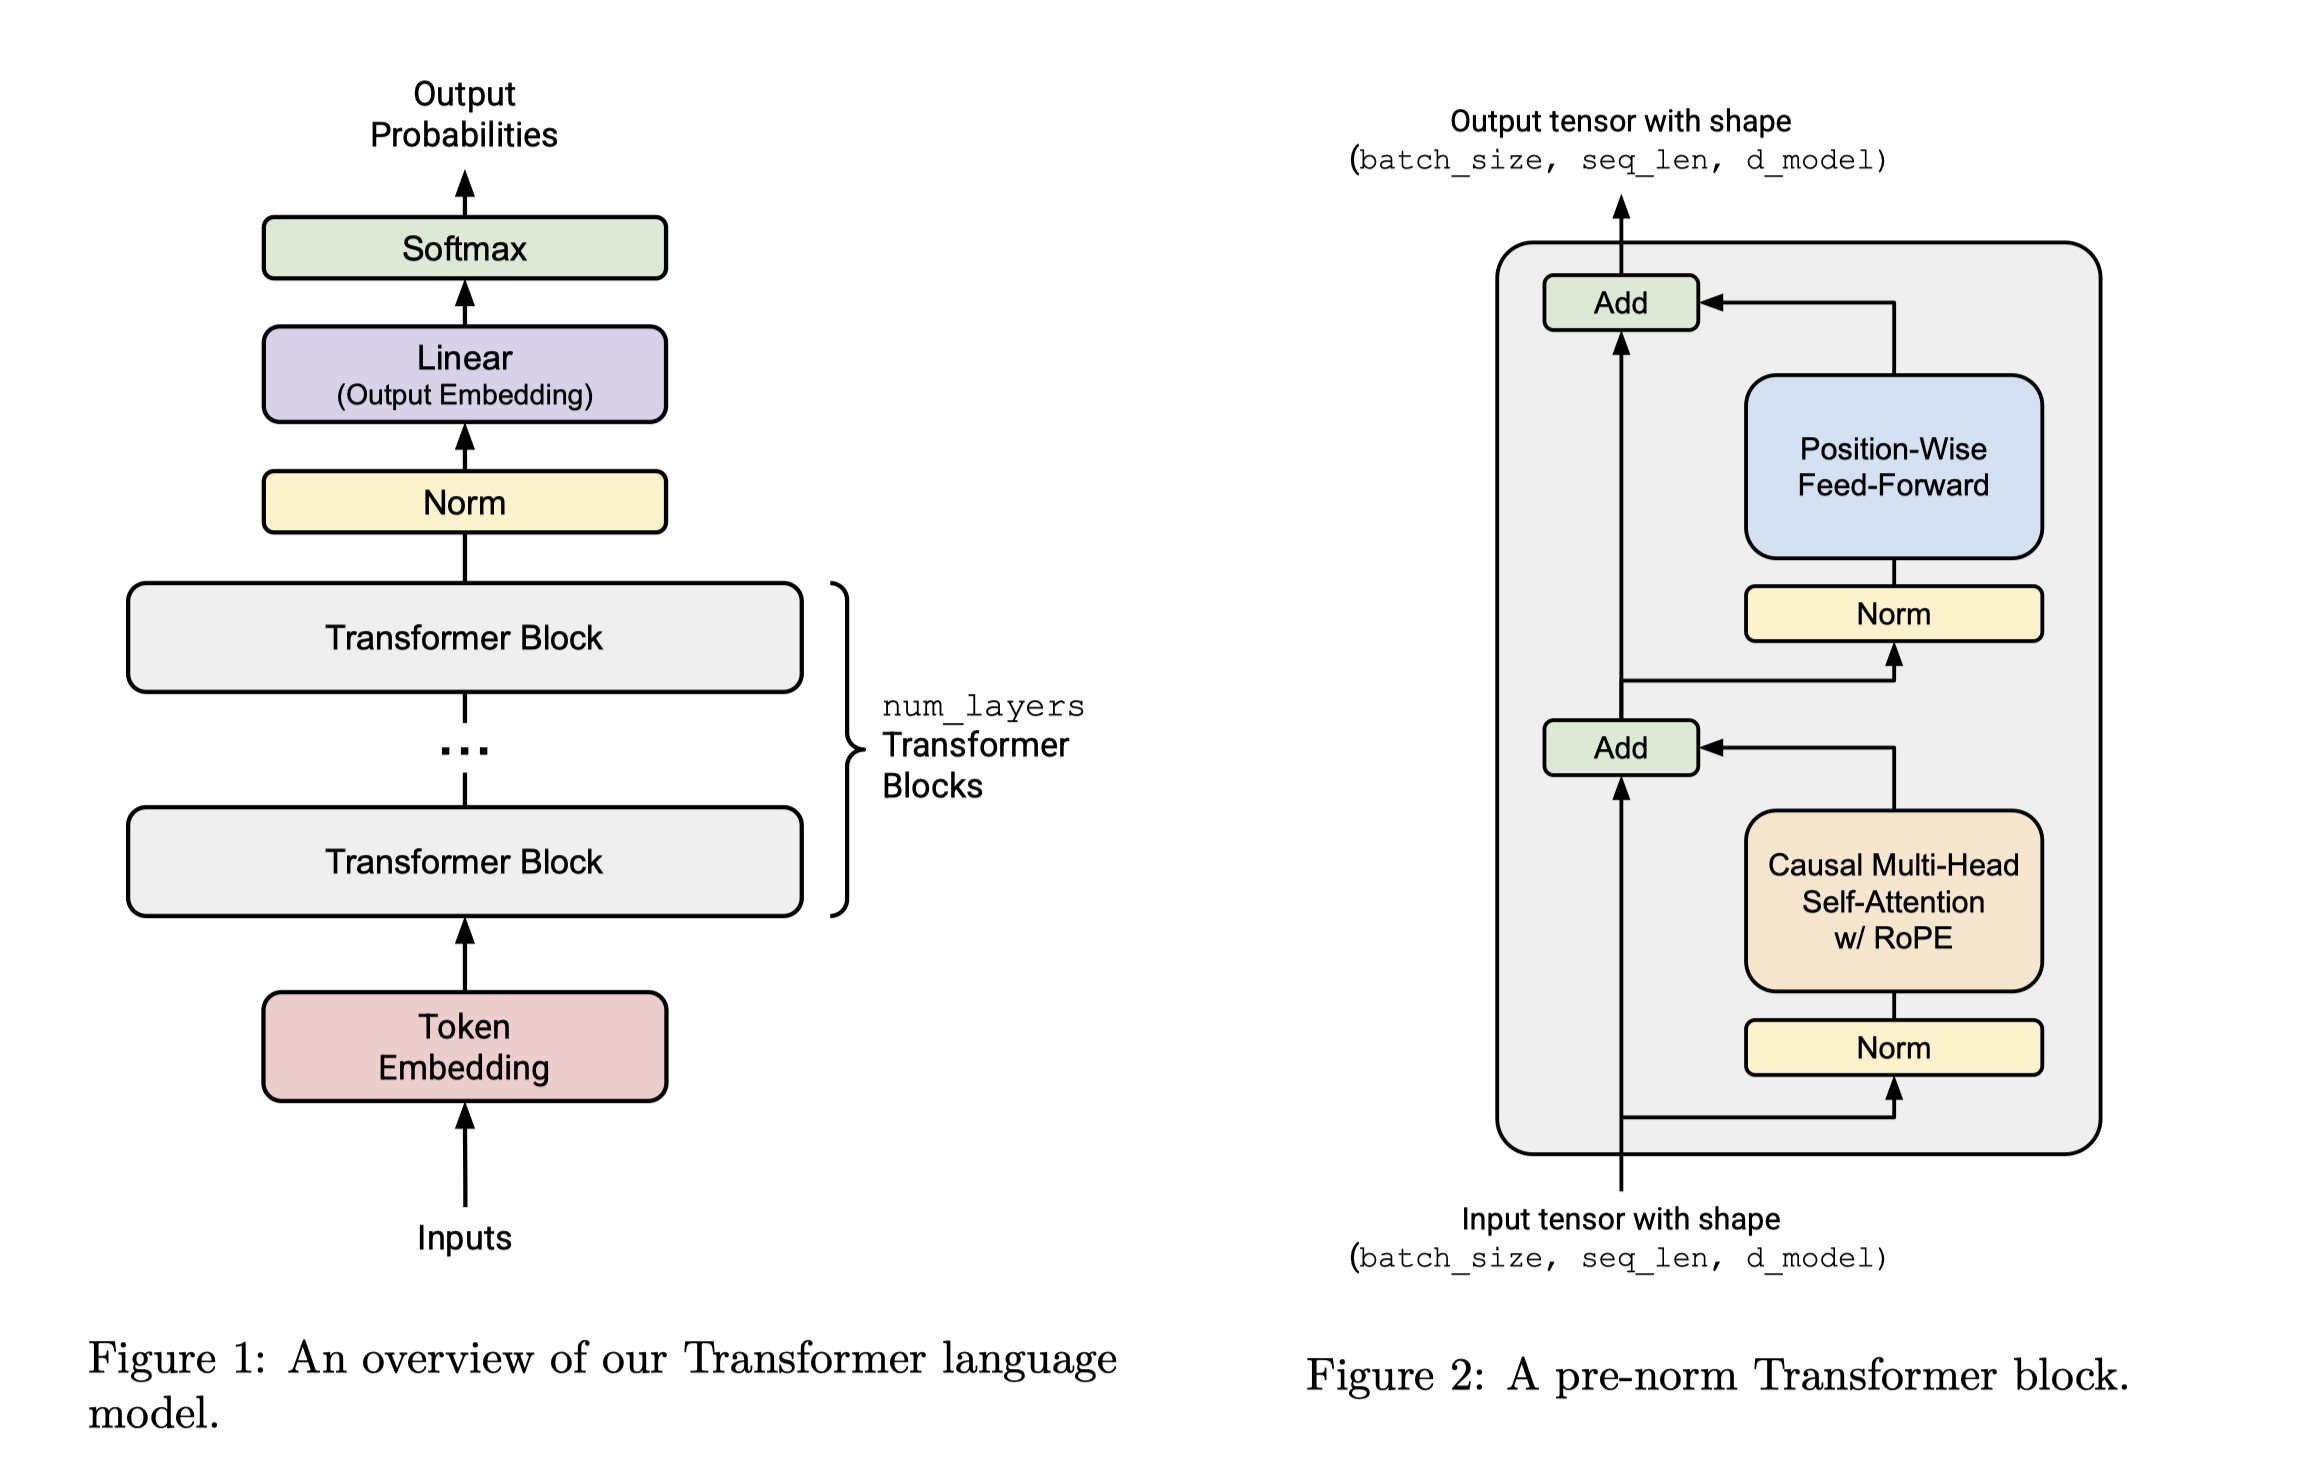

## 1. Einops and Einx

In [6]:
import torch 
from einops import rearrange, einsum

# Define D and A
D = torch.randn(2, 3, 4) # batch, sequence, d_in
A = torch.randn(6, 4) # d_in, d_out
## Basic implementation 
Y = D @ A.T 
# Hard to tell the input and output shapes and what they mean.

# What shapes can D and A have, and do any of these have unexpected behavior?

## Einsum is self-documenting and robust 
# # D A -> Y 
Y = einsum(D, A, "batch sequence d_in, d_out d_in -> batch sequence d_out")

## Or, a batched version where D can have any leading dimensions but A is constrained. 
Y = einsum(D, A, "... d_in, d_out d_in -> ... d_out")

In [19]:
print("D:", D)
print("A:", A)
print("Y:", Y)

D: tensor([[[ 0.1408,  2.1800,  2.2775,  0.4281],
         [-0.7714, -0.7374, -0.9821,  0.1189],
         [-0.3467,  0.0130, -1.6619, -0.9246]],

        [[ 0.5685,  2.5623, -0.7188,  0.2184],
         [-0.6598,  0.4450,  0.9321, -2.4852],
         [ 0.8681,  0.4347, -0.7243,  0.5954]]])
A: tensor([[ 0.7893, -0.2232, -1.1463,  0.5873],
        [ 0.4993, -0.1901,  0.0160,  0.8837],
        [ 0.7149, -0.8415, -0.3000, -1.1656],
        [-1.3980, -0.7648, -1.4021,  1.0012],
        [-1.0559,  2.0279,  0.2170, -0.2270],
        [-0.9001, -0.4990, -0.0104,  1.4983]])
Y: tensor([[[-2.7348,  0.0706, -2.9161, -4.6289,  4.6692, -0.5969],
         [ 0.7514, -0.1557,  0.2252,  3.1385, -0.9210,  1.2507],
         [ 1.0856, -1.0192,  1.3175,  1.8792,  0.2417, -1.0625]],

        [[ 0.8291, -0.0218, -1.7886, -1.5280,  4.3904, -1.4558],
         [-3.1481, -2.5953,  1.7708, -3.2132,  2.3654, -3.3614],
         [ 1.7681,  0.8654, -0.2219,  0.0658, -0.3274, -0.0986]]])


In [ ]:
images = torch.randn(64, 128, 128, 3) # (batch, height, width, channel) dim_by = torch.linspace(start=0.0, end=1.0, steps=10)
dim_by = torch.linspace(start=0.0, end=1.0, steps=10)
## Reshape and multiply 
dim_value = rearrange(dim_by, "dim_value -> 1 dim_value 1 1 1") 
images_rearr = rearrange(images, "b height width channel -> b 1 height width channel") 
dimmed_images = images_rearr * dim_value

## Or in one go: dimmed_images = einsum(

dimmed_images = einsum(
    images, dim_by,
    "batch height width channel, dim_value -> batch dim_value height width channel" 
)

NameError: name 'dim_by' is not defined